<a href="https://colab.research.google.com/github/FinalProjectEEE/FinalProject/blob/main/FinalProjectCodeWithDocumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following Python code simulates the computational model stages of the Neon Color Illusion. **Please note - running the code takes quite a long time, about 1 hour**, because of the part that solves laplace equations using iterative method.

In [ ]:
# Connecting to Google Drive

from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/My Drive/FinalProject/Neon_Color_Images/'
%ls
import os
path = os.getcwd()
print('path: ' + path)

Mounted at /content/drive/
/content/drive/My Drive/FinalProject/Neon_Color_Images
'NeonBlue sparse.png'           NeonColorLightBlue.png   NeonContour.png    triangle.png
 NeonColorBlue.png              NeonColor.png            net.png
 NeonColorGreen_Diffusion.png   NeonColorRedDense.png    OrangeSquare.png
 NeonColorGreen.png             NeonColorRedSparse.png   PinkSquare.png
path: /content/drive/My Drive/FinalProject/Neon_Color_Images


In [ ]:
# Importing needed libraries

%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from skimage import transform, io, util, img_as_float, img_as_ubyte
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage import restoration
import scipy.signal
from scipy.signal import medfilt2d
import cv2
from skimage.util import random_noise
import matplotlib.ticker as ticker
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from google.colab.patches import cv2_imshow
from skimage import exposure
from skimage.filters import rank
from skimage.filters.rank import autolevel_percentile
from collections import Counter
from scipy.ndimage import rotate
from scipy.signal import convolve2d
from PIL import Image
import PIL

The following part simulates the orthogonal completion and creation of contour model

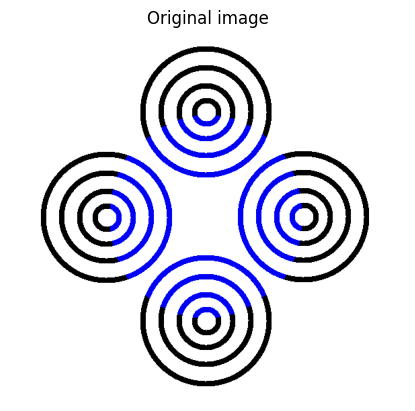

In [ ]:
# Upload original image

bgr_image = cv2.imread('NeonColorBlue.png')
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.show()

height, width = rgb_image.shape[:2]
for i in range(height):
  for j in range(width):
    if not np.array_equal(rgb_image[i, j], [255, 255, 255]) and not np.array_equal(rgb_image[i, j], [0, 0, 0]):
      y = i
      x = j
      break

y_chrom = y
x_chrom = x

y_background = 0
x_background = 0

In [ ]:
# Decompose the image into RGB channels

R_value = rgb_image[y_chrom, x_chrom][0]
G_value = rgb_image[y_chrom, x_chrom][1]
B_value = rgb_image[y_chrom, x_chrom][2]

red_channel, green_channel, blue_channel = cv2.split(rgb_image)

# Get values of RGB on the chromatic area:
R_gray_value = red_channel[y_chrom, x_chrom]
G_gray_value = green_channel[y_chrom, x_chrom]
B_gray_value = blue_channel[y_chrom, x_chrom]

channels_array = [R_value, G_value, B_value]

# Get the dominant color channel:
dominant_channel = np.argmax(channels_array)

if dominant_channel == 0:
  relevant_channel = red_channel
if dominant_channel == 1:
  relevant_channel = green_channel
if dominant_channel == 2:
  relevant_channel = blue_channel

<ipython-input-5-33127f7e68c0>:4: RuntimeWarning: invalid value encountered in scalar divide
  a_R = (255*R_gray_value - 0.5*R_gray_value*R_gray_value)/(255*R_gray_value*R_gray_value - 255*255*R_gray_value)
<ipython-input-5-33127f7e68c0>:5: RuntimeWarning: invalid value encountered in scalar divide
  a_G = (255*G_gray_value - 0.5*G_gray_value*G_gray_value)/(255*G_gray_value*G_gray_value - 255*255*G_gray_value)
<ipython-input-5-33127f7e68c0>:8: RuntimeWarning: invalid value encountered in scalar divide
  b_R = (-255*255*R_gray_value + 0.5*R_gray_value*R_gray_value*R_gray_value)/(255*R_gray_value*R_gray_value - 255*255*R_gray_value)
<ipython-input-5-33127f7e68c0>:9: RuntimeWarning: invalid value encountered in scalar divide
  b_G = (-255*255*G_gray_value + 0.5*G_gray_value*G_gray_value*G_gray_value)/(255*G_gray_value*G_gray_value - 255*255*G_gray_value)


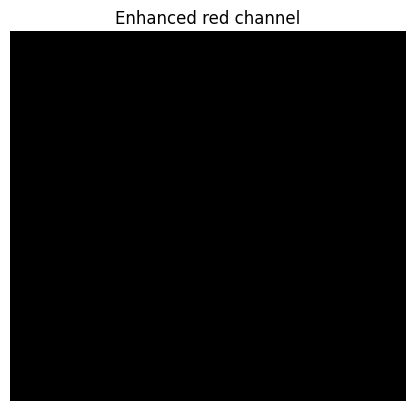

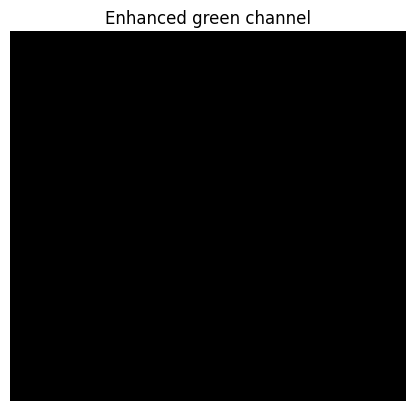

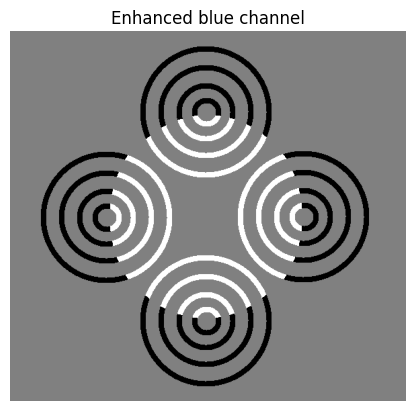

In [ ]:
# Enhance color channel

# Perform a contrast transformation for every color channel (channels that have 0 value in the chromatic area, will remain 0):
a_R = (255*R_gray_value - 0.5*R_gray_value*R_gray_value)/(255*R_gray_value*R_gray_value - 255*255*R_gray_value)
a_G = (255*G_gray_value - 0.5*G_gray_value*G_gray_value)/(255*G_gray_value*G_gray_value - 255*255*G_gray_value)
a_B = (255*B_gray_value - 0.5*B_gray_value*B_gray_value)/(255*B_gray_value*B_gray_value - 255*255*B_gray_value)

b_R = (-255*255*R_gray_value + 0.5*R_gray_value*R_gray_value*R_gray_value)/(255*R_gray_value*R_gray_value - 255*255*R_gray_value)
b_G = (-255*255*G_gray_value + 0.5*G_gray_value*G_gray_value*G_gray_value)/(255*G_gray_value*G_gray_value - 255*255*G_gray_value)
b_B = (-255*255*B_gray_value + 0.5*B_gray_value*B_gray_value*B_gray_value)/(255*B_gray_value*B_gray_value - 255*255*B_gray_value)

I_LUM = 0.299*red_channel + 0.587*green_channel + 0.114*blue_channel
k = 0.5

if R_gray_value == 255:
  red_enhanced = red_channel - k*I_LUM
if R_gray_value != 255:
  red_enhanced = a_R*red_channel*red_channel + b_R*red_channel
if R_gray_value == 0:
  red_enhanced = 0*red_channel

if G_gray_value == 255:
  green_enhanced = green_channel - k*I_LUM
if G_gray_value != 255:
  green_enhanced = a_G*green_channel*green_channel + b_G*green_channel
if G_gray_value == 0:
  green_enhanced = 0*green_channel

if B_gray_value == 255:
  blue_enhanced = blue_channel - k*I_LUM
if B_gray_value != 255:
  blue_enhanced = a_B*blue_channel*blue_channel + b_B*blue_channel
if B_gray_value == 0:
  blue_enhanced = 0*blue_channel

plt.imshow(red_enhanced, cmap='gray')
plt.title('Enhanced red channel')
plt.axis('off')
plt.show()
plt.imshow(green_enhanced, cmap='gray')
plt.title('Enhanced green channel')
plt.axis('off')
plt.show()
plt.imshow(blue_enhanced, cmap='gray')
plt.title('Enhanced blue channel')
plt.axis('off')
plt.show()

In [ ]:
# Defining approximated Gabor filters

G_odd_x = np.array([[-1,1]])
G_odd_y = np.array([[-1],[1]])

In [ ]:
# Perform convolution with Gabor filters to detect edges on the image in x direction and in y direction

def ConvolutionWithGabor(color_enhanced):
  I_Gabor_x = np.abs(scipy.signal.convolve2d(color_enhanced, G_odd_x, mode='same'))
  I_Gabor_y = np.abs(scipy.signal.convolve2d(color_enhanced, G_odd_y, mode='same'))
  return I_Gabor_x, I_Gabor_y

In [ ]:
# Apply thershold to extract edges only between chromatic and not chromatic areas

def ApplyThreshold(I_Gabor_x, I_Gabor_y, threshold):
  max_val_x = np.max(I_Gabor_x)
  height, width = I_Gabor_x.shape
  for i in range(height):
    for j in range(width):
      if I_Gabor_x[i, j] <= threshold*max_val_x:
        I_Gabor_x[i, j] = 0
  I_Gabor_Th_x = I_Gabor_x

  max_val_y = np.max(I_Gabor_y)
  height, width = I_Gabor_y.shape
  for i in range(height):
    for j in range(width):
      if I_Gabor_y[i, j] <= threshold*max_val_y:
        I_Gabor_y[i, j] = 0
  I_Gabor_Th_y = I_Gabor_y

  return I_Gabor_Th_x, I_Gabor_Th_y, max_val_y

In [ ]:
# Combine direction x with direction y by summation

def CombineThresholdEdges(I_Gabor_Th_x, I_Gabor_Th_y):
  I_Edges = I_Gabor_Th_x + I_Gabor_Th_y
  return I_Edges

In [ ]:
# Apply additional threshold to make all edges with the same gray level

def ApplyAdditionalThreshold(I_Edges, max_val_y):
  max_val = np.max(I_Edges)
  min_val = np.min(I_Edges)
  height, width = I_Gabor_y.shape
  for i in range(height):
    for j in range(width):
      if I_Edges[i, j] <= 0.8*max_val_y:
        I_Edges[i, j] = 0
      else:
        I_Edges[i, j] = max_val

  return I_Edges

In [ ]:
# Finding the orientation of each detected edge by separating the edges based on gaps between them

def FindOrientations(I_Edges):

  def compute_angles(image):
      #Compute the angle of each white pixel relative to the center of the image:
      height, width = image.shape
      y, x = np.nonzero(image)  # Find white pixel coordinates

      center_x, center_y = width // 2, height // 2  # Center of the image

      angles = np.arctan2(y - center_y, x - center_x) % (2 * np.pi)  # Compute angle

      return np.array(list(zip(y, x))), angles

  def group_angles(angles, pixels, threshold=0.05):

      sorted_indices = np.argsort(angles)
      sorted_angles = angles[sorted_indices]
      sorted_pixels = np.array(pixels)[sorted_indices]

      # Find gaps between angles to determine group boundaries:
      gaps = np.diff(sorted_angles, prepend=sorted_angles[-1] - 2 * np.pi)
      groups = np.cumsum(gaps > threshold)

      return sorted_pixels, sorted_angles, groups

  def line_angle_and_pixel(pixels, angles, groups):
      # Compute the line angle and midpoint pixel for each line group:
      unique_groups = np.unique(groups)
      results = []

      for group in unique_groups:
          group_indices = np.where(groups == group)[0]
          group_pixels = pixels[group_indices]
          group_angles = angles[group_indices]

          # Get edge angles and their corresponding pixels:
          min_angle_idx = np.argmin(group_angles)
          max_angle_idx = np.argmax(group_angles)

          pixel1 = group_pixels[min_angle_idx]
          pixel2 = group_pixels[max_angle_idx]

          # Compute line angle:
          dx = pixel2[1] - pixel1[1]
          dy = pixel2[0] - pixel1[0]
          line_angle = np.arctan2(dy, dx) % (2 * np.pi)

          # Compute midpoint pixel:
          midpoint_pixel = tuple(np.round((np.array(pixel1) + np.array(pixel2)) / 2).astype(int))

          results.append((midpoint_pixel, line_angle))

      return results

  def detect_lines(image):
      # Detect edges in the image and return their representative pixels and angles:

      pixels, angles = compute_angles(image)  # Compute angles

      pixels, angles, groups = group_angles(angles, pixels)  # Group angles

      result = line_angle_and_pixel(pixels, angles, groups)  # Compute line angles and midpoints

      return result

  result = detect_lines(I_Edges)
  return result

In [ ]:
# Creating the contour image after applying additive signal

def AdditiveSignal(I_Edges, result, a, b):

  def generate_oriented_gaussian(size, x_cen, y_cen, a, b, angle):
      # Generate a 2D Gaussian function centered at (x_cen, y_cen) and oriented at a specific angle:
      x, y = np.meshgrid(np.arange(size[1]), np.arange(size[0]))  # x = columns, y = rows

      x -= x_cen
      y -= y_cen

      cos_angle = np.cos(angle)
      sin_angle = np.sin(angle)
      x_rot = cos_angle * x + sin_angle * y
      y_rot = -sin_angle * x + cos_angle * y

      gaussian = np.exp(-0.5 * (x_rot**2 / a**2 + y_rot**2 / b**2))
      return gaussian

  def add_oriented_gaussians(image, result, a, b):
      # Add oriented 2D Gaussians to the image, each Gaussian fits a specific edge with it corresponding orientation angle:
      height, width = image.shape
      output_image = np.zeros((height, width), dtype=np.float64)

      for (row, col), angle in result:
          # Generate Gaussian centered at (col, row) with the given orientation:
          gaussian = generate_oriented_gaussian((height, width), col, row, a, b, angle)

          # Multiply Gaussian by the grayscale value of the pixel on the edge:
          max_val = np.max(I_Edges)
          gaussian *= 0.35*max_val  # M = 0.35

          # Add the Gaussian image to the output image:
          output_image += gaussian

      return output_image

  # Add oriented Gaussians to the image:
  final_image = add_oriented_gaussians(I_Edges, result, a, b)
  facilitated_image = final_image + I_Edges

  max_fac = np.max(facilitated_image)
  height, width = facilitated_image.shape
  for i in range(1, height - 1):
    for j in range(1, width - 1):
      if facilitated_image[i, j] <= 0.02*max_fac:
        facilitated_image[i, j] = 0

  return facilitated_image  # The image with the contour (in grayscale)

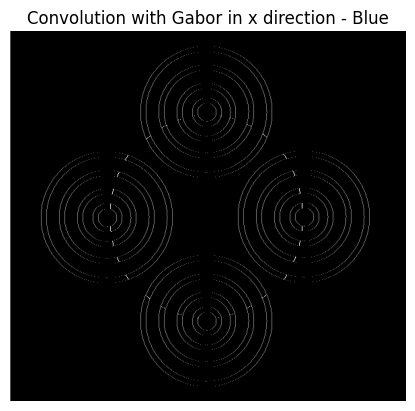

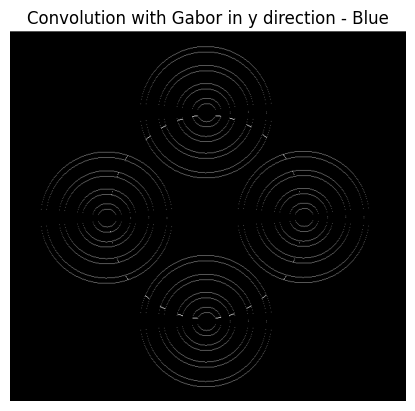

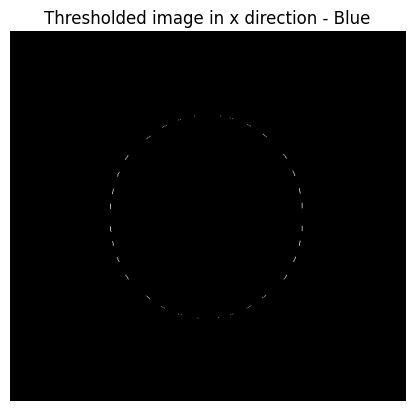

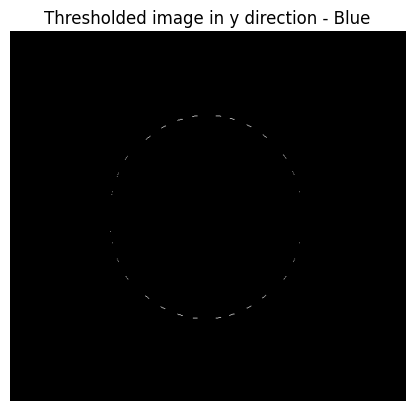

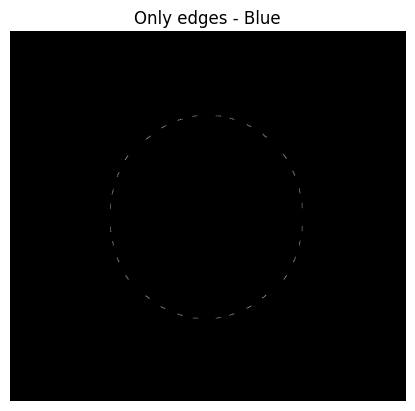

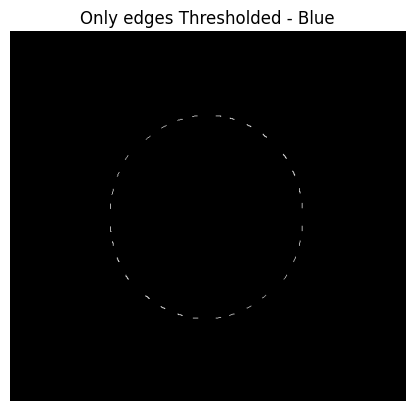

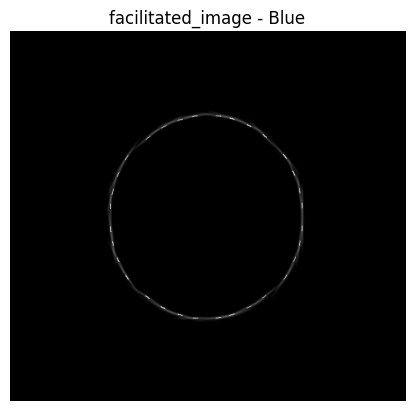

In [ ]:
# Applying all the previous functions on each enhanced color channel

# For red channel:

if R_value != 0:

  I_Gabor_x, I_Gabor_y = ConvolutionWithGabor(red_enhanced)
  plt.imshow(I_Gabor_x, cmap='gray')
  plt.title('Convolution with Gabor in x direction - Red')
  plt.axis('off')
  plt.show()
  plt.imshow(I_Gabor_y, cmap='gray')
  plt.title('Convolution with Gabor in y direction - Red')
  plt.axis('off')
  plt.show()

  I_Gabor_Th_x, I_Gabor_Th_y, max_val_y = ApplyThreshold(I_Gabor_x, I_Gabor_y, 0.9)
  plt.imshow(I_Gabor_Th_x, cmap='gray')
  plt.title('Thresholded image in x direction - Red')
  plt.axis('off')
  plt.show()
  plt.imshow(I_Gabor_Th_y, cmap='gray')
  plt.title('Thresholded image in y direction - Red')
  plt.axis('off')
  plt.show()

  I_Edges = CombineThresholdEdges(I_Gabor_Th_x, I_Gabor_Th_y)
  plt.imshow(I_Edges, cmap='gray')
  plt.title('Only edges - Red')
  plt.axis('off')
  plt.show()

  I_Edges = ApplyAdditionalThreshold(I_Edges, max_val_y)
  plt.imshow(I_Edges, cmap='gray')
  plt.title('Only edges Thresholded - Red')
  plt.axis('off')
  plt.show()

  result = FindOrientations(I_Edges)

  a = 17
  b = 1.2
  facilitated_image_red = AdditiveSignal(I_Edges, result, a, b)
  plt.imshow(facilitated_image_red, cmap='gray')
  plt.title('facilitated_image - Red')
  plt.axis('off')
  plt.show()

else:
  height, width = red_channel.shape
  facilitated_image_red = np.zeros((height, width))

# For green channel:

if G_value != 0:

  I_Gabor_x, I_Gabor_y = ConvolutionWithGabor(green_enhanced)
  plt.imshow(I_Gabor_x, cmap='gray')
  plt.title('Convolution with Gabor in x direction - Green')
  plt.axis('off')
  plt.show()
  plt.imshow(I_Gabor_y, cmap='gray')
  plt.title('Convolution with Gabor in y direction - Green')
  plt.axis('off')
  plt.show()

  I_Gabor_Th_x, I_Gabor_Th_y, max_val_y = ApplyThreshold(I_Gabor_x, I_Gabor_y, 0.8)
  plt.imshow(I_Gabor_Th_x, cmap='gray')
  plt.title('Thresholded image in x direction - Green')
  plt.axis('off')
  plt.show()
  plt.imshow(I_Gabor_Th_y, cmap='gray')
  plt.title('Thresholded image in y direction - Green')
  plt.axis('off')
  plt.show()

  I_Edges = CombineThresholdEdges(I_Gabor_Th_x, I_Gabor_Th_y)
  plt.imshow(I_Edges, cmap='gray')
  plt.title('Only edges - Green')
  plt.axis('off')
  plt.show()

  I_Edges = ApplyAdditionalThreshold(I_Edges, max_val_y)
  plt.imshow(I_Edges, cmap='gray')
  plt.title('Only edges Thresholded - Green')
  plt.axis('off')
  plt.show()

  result = FindOrientations(I_Edges)

  a = 17
  b = 1.2
  facilitated_image_green = AdditiveSignal(I_Edges, result, a, b)
  plt.imshow(facilitated_image_green, cmap='gray')
  plt.title('facilitated_image - Green')
  plt.axis('off')
  plt.show()

else:
  height, width = green_channel.shape
  facilitated_image_green = np.zeros((height, width))

# For blue channel:

if B_value != 0:

  I_Gabor_x, I_Gabor_y = ConvolutionWithGabor(blue_enhanced)
  plt.imshow(I_Gabor_x, cmap='gray')
  plt.title('Convolution with Gabor in x direction - Blue')
  plt.axis('off')
  plt.show()
  plt.imshow(I_Gabor_y, cmap='gray')
  plt.title('Convolution with Gabor in y direction - Blue')
  plt.axis('off')
  plt.show()

  I_Gabor_Th_x, I_Gabor_Th_y, max_val_y = ApplyThreshold(I_Gabor_x, I_Gabor_y, 0.8)
  plt.imshow(I_Gabor_Th_x, cmap='gray')
  plt.title('Thresholded image in x direction - Blue')
  plt.axis('off')
  plt.show()
  plt.imshow(I_Gabor_Th_y, cmap='gray')
  plt.title('Thresholded image in y direction - Blue')
  plt.axis('off')
  plt.show()

  I_Edges = CombineThresholdEdges(I_Gabor_Th_x, I_Gabor_Th_y)
  plt.imshow(I_Edges, cmap='gray')
  plt.title('Only edges - Blue')
  plt.axis('off')
  plt.show()

  I_Edges = ApplyAdditionalThreshold(I_Edges, max_val_y)
  plt.imshow(I_Edges, cmap='gray')
  plt.title('Only edges Thresholded - Blue')
  plt.axis('off')
  plt.show()

  result = FindOrientations(I_Edges)

  a = 17
  b = 1.2
  facilitated_image_blue = AdditiveSignal(I_Edges, result, a, b)
  plt.imshow(facilitated_image_blue, cmap='gray')
  plt.title('facilitated_image - Blue')
  plt.axis('off')
  plt.show()

else:
  height, width = blue_channel.shape
  facilitated_image_blue = np.zeros((height, width))

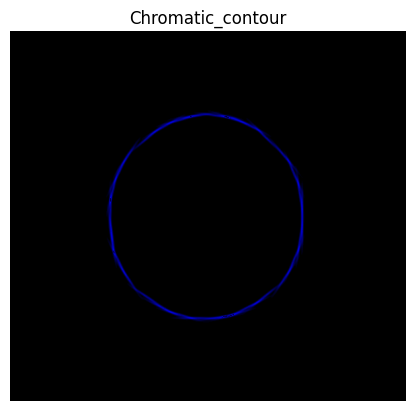

In [ ]:
# Transform the contour image into color:

facilitated_image_red = facilitated_image_red.astype(np.uint8)
facilitated_image_green = facilitated_image_green.astype(np.uint8)
facilitated_image_blue = facilitated_image_blue.astype(np.uint8)

color_contour = cv2.merge([facilitated_image_red, facilitated_image_green, facilitated_image_blue])

height, width = facilitated_image_blue.shape
color_contour = np.zeros((height, width, 3), dtype=np.uint8)

color_contour[..., 0] = (R_value/255) * facilitated_image_red
color_contour[..., 1] = (G_value/255) * facilitated_image_green
color_contour[..., 2] = (B_value/255) * facilitated_image_blue

plt.imshow(color_contour)
plt.title('Chromatic_contour')
plt.axis('off')
plt.show()

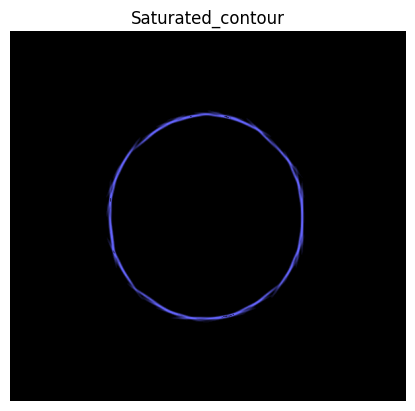

In [ ]:
# Change the saturation/value of the color of the contour:

def enhance_saturation(image, channel, increase_factor_sat = 0.6, increase_factor_val=1.5):  # Channel must be 0 (H), 1 (S), or 2 (V)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * increase_factor_sat, 0, 255)
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * increase_factor_val, 0, 255)

    # Convert back to RGB
    result_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

    return result_image

Saturated_contour = enhance_saturation(color_contour, 2)
plt.imshow(Saturated_contour)
plt.title('Saturated_contour')
plt.axis('off')
plt.show()

The following part simulates the diffusion model

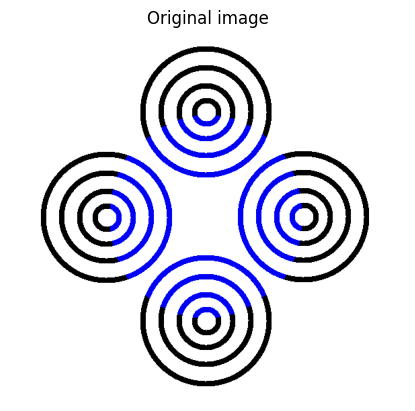

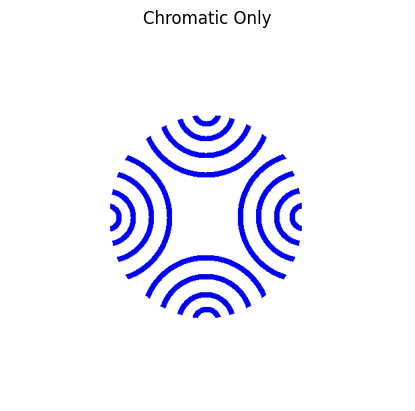

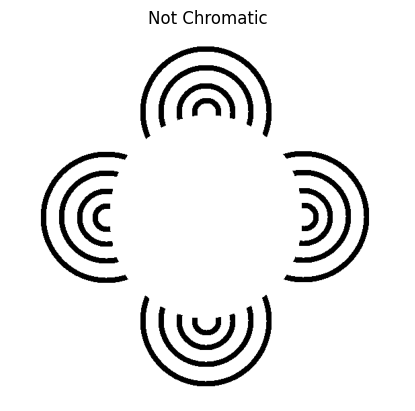

In [ ]:
# Upload original image

bgr_image = cv2.imread('NeonColorBlue.png')
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.show()

# Decompose the image into chromatic and not chromatic parts and find pixel on the chromatic part and on the not chromatic part

height, width = rgb_image.shape[:2]
for i in range(height):
  for j in range(width):
    if not np.array_equal(rgb_image[i, j], [255, 255, 255]) and not np.array_equal(rgb_image[i, j], [0, 0, 0]):
      y = i
      x = j
      break

y_chrom = y
x_chrom = x

y_background = 0
x_background = 0

# Create a mask for chromatic areas (non-white and non-black pixels):
black_threshold = np.array([0, 0, 0])

# Create a mask for not chromatic and chromatic pixels:
mask_not_chromatic = rgb_image == black_threshold
mask_not_chromatic = mask_not_chromatic.all(axis=-1)
mask_chromatic = rgb_image > black_threshold
mask_chromatic = mask_chromatic.any(axis=-1)  # Combine channels

# Create a new image with a white background:
chromatic_only = np.ones_like(rgb_image) * 255
not_chromatic_only = np.ones_like(rgb_image) * 255

# Copy the chromatic areas to the result image
chromatic_only[mask_chromatic] = rgb_image[mask_chromatic]
not_chromatic_only[mask_not_chromatic] = rgb_image[mask_not_chromatic]

plt.imshow(chromatic_only)
plt.title('Chromatic Only')
plt.axis('off')
plt.show()
plt.imshow(not_chromatic_only)
plt.title('Not Chromatic')
plt.axis('off')
plt.show()

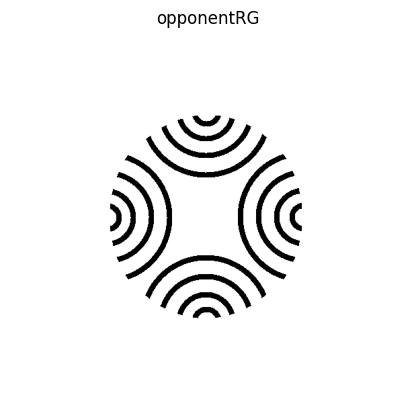

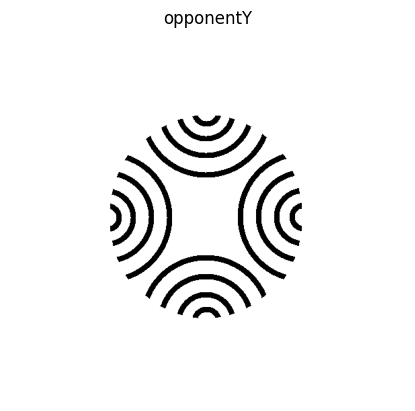

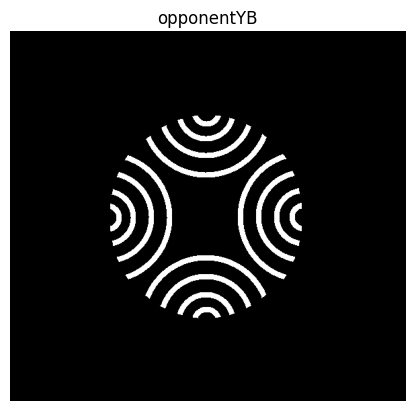

In [ ]:
# Defining the opponent color channels

red_channel, green_channel, blue_channel = cv2.split(chromatic_only)

opponentRG_channel = -0.0971*red_channel + 0.1458*green_channel - 0.0250*blue_channel
opponentY_channel = 0.2814*red_channel + 0.6938*green_channel + 0.0638*blue_channel
opponentYB_channel = -0.0930*red_channel -0.2529*green_channel + 0.4665*blue_channel

plt.imshow(opponentRG_channel, cmap='gray')
plt.title('opponentRG')
plt.axis('off')
plt.show()
plt.imshow(opponentY_channel, cmap='gray')
plt.title('opponentY')
plt.axis('off')
plt.show()
plt.imshow(opponentYB_channel, cmap='gray')
plt.title('opponentYB')
plt.axis('off')
plt.show()

# Find gray level values of the chromatic and not chromatic parts in each channel:

RG_chrom = opponentRG_channel[y_chrom, x_chrom]
Y_chrom = opponentY_channel[y_chrom, x_chrom]
BY_chrom = opponentYB_channel[y_chrom, x_chrom]

RG_background = opponentRG_channel[y_background, x_background]
Y_background = opponentY_channel[y_background, x_background]
BY_background = opponentYB_channel[y_background, x_background]

In [ ]:
# Defining approximated Gabor filters

G_odd_x = np.array([[-1,1]])
G_odd_y = np.array([[-1],[1]])

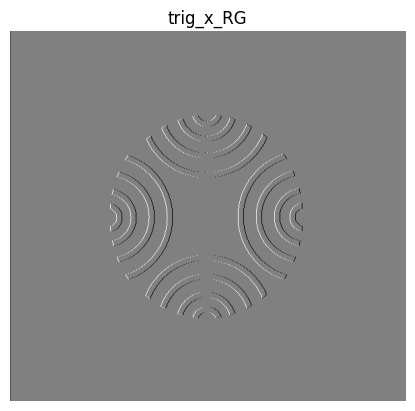

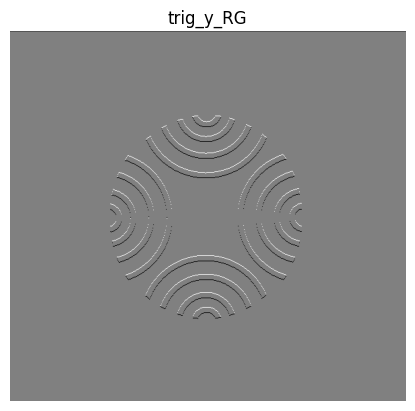

In [ ]:
# Trigger - RG channel

ODO_x_RG = scipy.signal.convolve2d(opponentRG_channel, G_odd_x, mode='same')
trig_x_RG = ODO_x_RG
plt.imshow(trig_x_RG, cmap = 'gray')
plt.axis('off')
plt.title('trig_x_RG')
plt.show()

ODO_y_RG = scipy.signal.convolve2d(opponentRG_channel, G_odd_y, mode='same')
trig_y_RG = ODO_y_RG
plt.imshow(trig_y_RG, cmap = 'gray')
plt.axis('off')
plt.title('trig_y_RG')
plt.show()

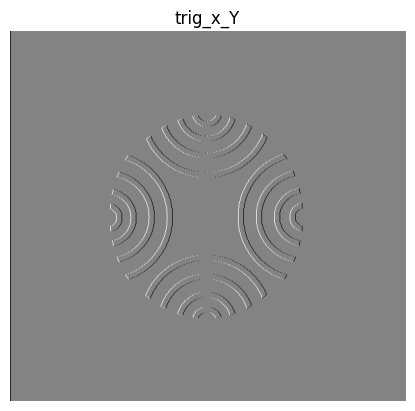

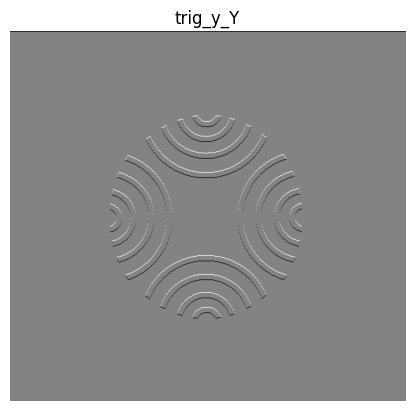

In [ ]:
# Trigger - Y channel

ODO_x_Y = scipy.signal.convolve2d(opponentY_channel, G_odd_x, mode='same')
trig_x_Y = ODO_x_Y
plt.imshow(trig_x_Y, cmap = 'gray')
plt.axis('off')
plt.title('trig_x_Y')
plt.show()

ODO_y_Y = scipy.signal.convolve2d(opponentY_channel, G_odd_y, mode='same')
trig_y_Y = ODO_y_Y
plt.imshow(trig_y_Y, cmap = 'gray')
plt.axis('off')
plt.title('trig_y_Y')
plt.show()

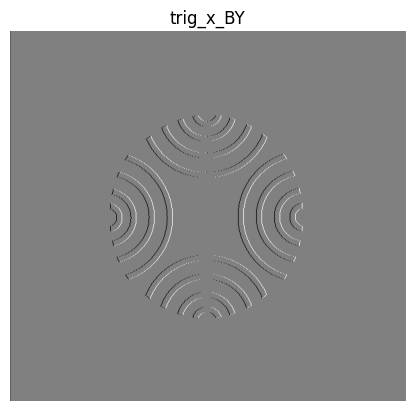

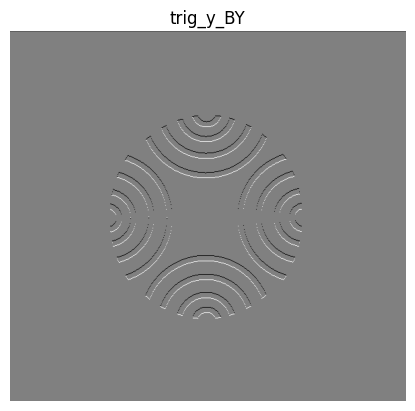

In [ ]:
# Trigger - BY channel

ODO_x_BY = scipy.signal.convolve2d(opponentYB_channel, G_odd_x, mode='same')
trig_x_BY = ODO_x_BY
plt.imshow(trig_x_BY, cmap = 'gray')
plt.axis('off')
plt.title('trig_x_BY')
plt.show()

ODO_y_BY = scipy.signal.convolve2d(opponentYB_channel, G_odd_y, mode='same')
trig_y_BY = ODO_y_BY
plt.imshow(trig_y_BY, cmap = 'gray')
plt.axis('off')
plt.title('trig_y_BY')
plt.show()

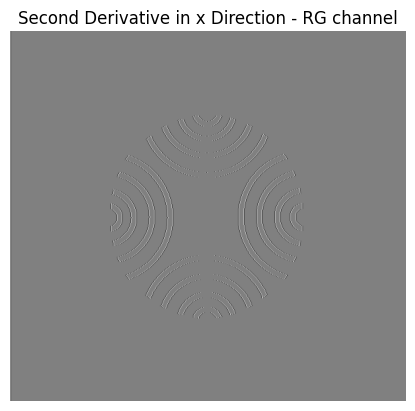

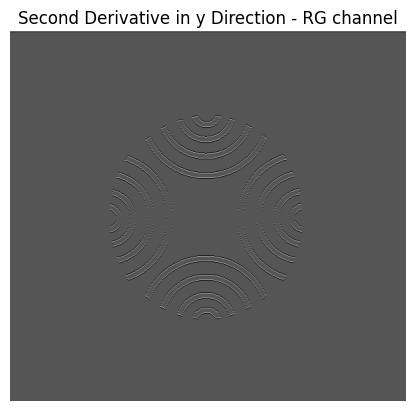

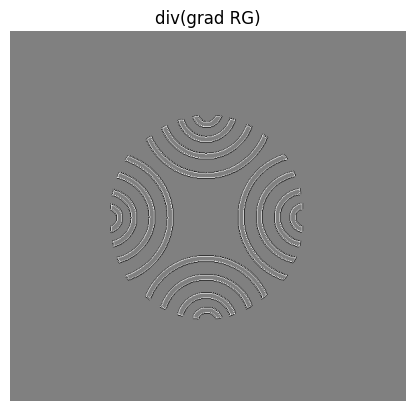

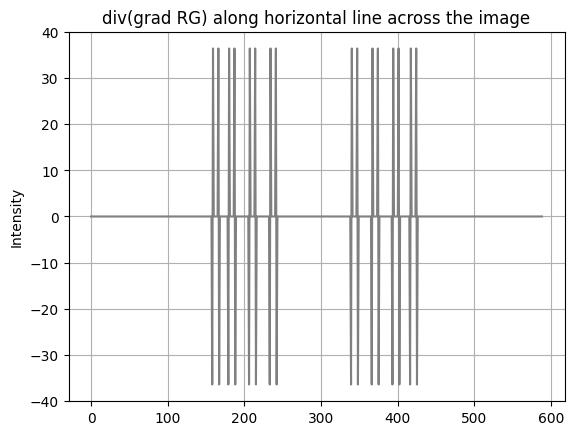

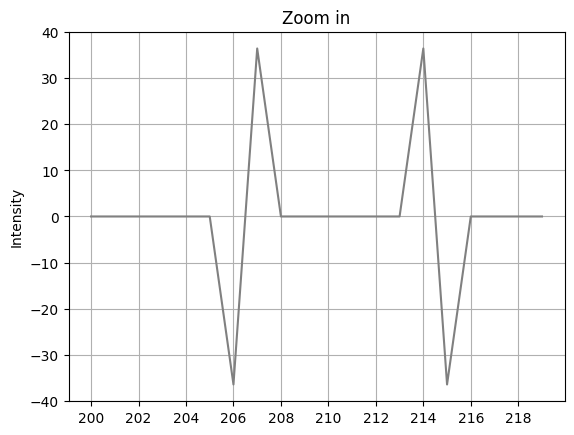

In [ ]:
# Divergence of the trigger - RG

Second_Derivative_x_RG = scipy.signal.convolve2d(trig_x_RG, G_odd_x, mode='same')
plt.imshow(Second_Derivative_x_RG, cmap = 'gray')
plt.axis('off')
plt.title('Second Derivative in x Direction - RG channel')
plt.show()

Second_Derivative_y_RG = scipy.signal.convolve2d(trig_y_RG, G_odd_y, mode='same')
plt.imshow(Second_Derivative_y_RG, cmap = 'gray')
plt.axis('off')
plt.title('Second Derivative in y Direction - RG channel')
plt.show()

Div_of_Trig_RG = Second_Derivative_x_RG + Second_Derivative_y_RG

Div_of_Trig_RG[:, 0] = 0
Div_of_Trig_RG[:, -1] = 0
Div_of_Trig_RG[0, :] = 0
Div_of_Trig_RG[-1, :] = 0

Div_of_Trig_RG[:, 1] = 0
Div_of_Trig_RG[:, -2] = 0
Div_of_Trig_RG[1, :] = 0
Div_of_Trig_RG[-2, :] = 0

div_max = np.max(Div_of_Trig_RG)
div_min = np.min(Div_of_Trig_RG)

height, width = Div_of_Trig_RG.shape

for i in range(height):
  for j in range(width):
    if Div_of_Trig_RG[i, j] > 0:
      Div_of_Trig_RG[i, j] = div_max
    if Div_of_Trig_RG[i, j] < 0:
      Div_of_Trig_RG[i, j] = div_min

plt.imshow(Div_of_Trig_RG, cmap = 'gray')
plt.title('div(grad RG)')
plt.axis('off')
plt.show()

height, width = Div_of_Trig_RG.shape

center_y = height // 2
line_values = Div_of_Trig_RG[center_y, :]
plt.plot(line_values, color='gray')
plt.title('div(grad RG) along horizontal line across the image')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.show()

line_values = Div_of_Trig_RG[center_y, 200:220]
plt.plot(range(200, 220), line_values, color='gray')
plt.title('Zoom in')
plt.xlabel('')
plt.ylabel('Intensity')
plt.xticks(range(200, 220, 2))
plt.grid()
plt.show()

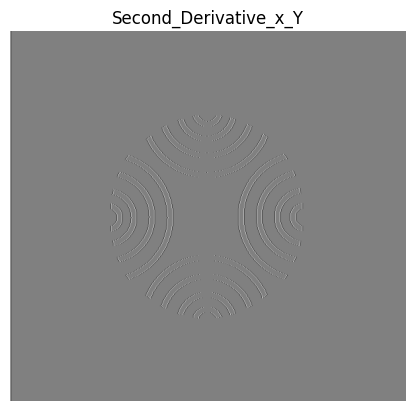

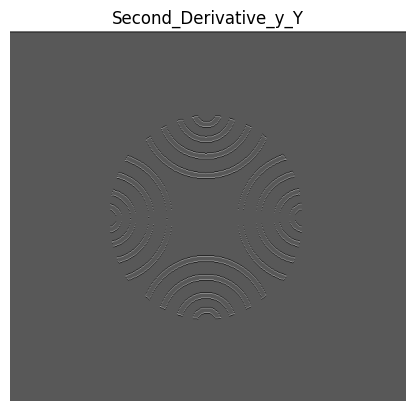

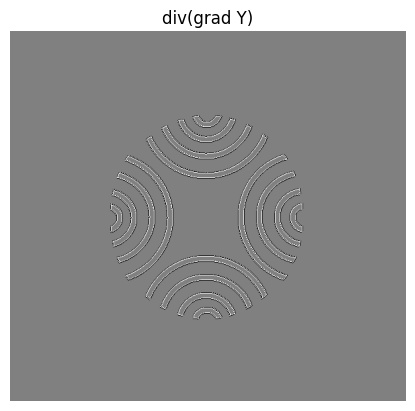

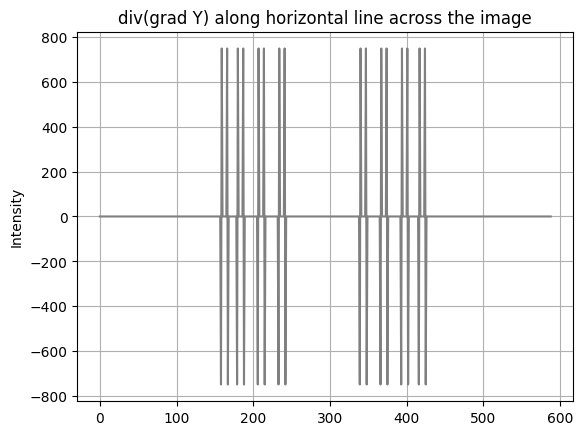

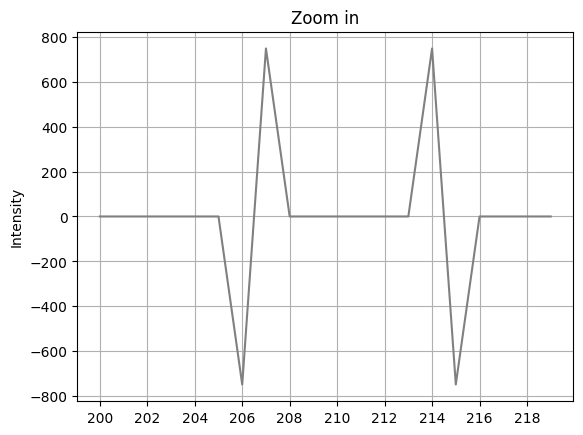

In [ ]:
# Divergence of gradient - Y

Second_Derivative_x_Y = scipy.signal.convolve2d(trig_x_Y, G_odd_x, mode='same')
plt.imshow(Second_Derivative_x_Y, cmap = 'gray')
plt.axis('off')
plt.title('Second_Derivative_x_Y')
plt.show()

Second_Derivative_y_Y = scipy.signal.convolve2d(trig_y_Y, G_odd_y, mode='same')
plt.imshow(Second_Derivative_y_Y, cmap = 'gray')
plt.axis('off')
plt.title('Second_Derivative_y_Y')
plt.show()

Div_of_Trig_Y = Second_Derivative_x_Y + Second_Derivative_y_Y

Div_of_Trig_Y[:, 0] = 0
Div_of_Trig_Y[:, -1] = 0
Div_of_Trig_Y[0, :] = 0
Div_of_Trig_Y[-1, :] = 0

Div_of_Trig_Y[:, 1] = 0
Div_of_Trig_Y[:, -2] = 0
Div_of_Trig_Y[1, :] = 0
Div_of_Trig_Y[-2, :] = 0

div_max = np.max(Div_of_Trig_Y)
div_min = np.min(Div_of_Trig_Y)

height, width = Div_of_Trig_Y.shape

for i in range(height):
  for j in range(width):
    if Div_of_Trig_Y[i, j] > 0:
      Div_of_Trig_Y[i, j] = div_max
    if Div_of_Trig_Y[i, j] < 0:
      Div_of_Trig_Y[i, j] = div_min

plt.imshow(Div_of_Trig_Y, cmap = 'gray')
plt.title('div(grad Y)')
plt.axis('off')
plt.show()

height, width = Div_of_Trig_Y.shape

center_y = height // 2

line_values = Div_of_Trig_Y[center_y, :]
plt.plot(line_values, color='gray')
plt.title('div(grad Y) along horizontal line across the image')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.show()

line_values = Div_of_Trig_Y[center_y, 200:220]
plt.plot(range(200, 220), line_values, color='gray')
plt.title('Zoom in')
plt.xlabel('')
plt.ylabel('Intensity')
plt.xticks(range(200, 220, 2))
plt.grid()
plt.show()

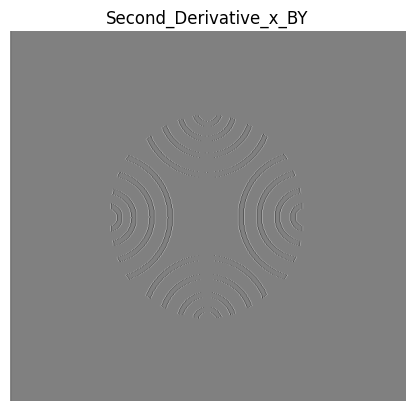

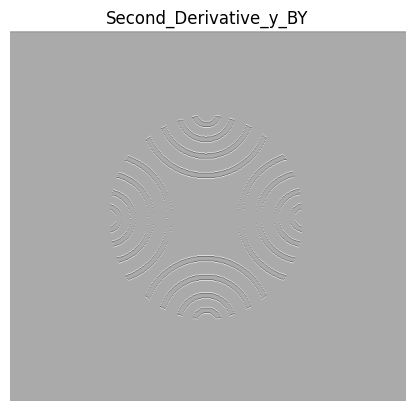

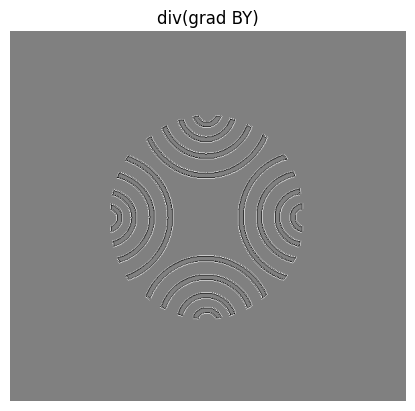

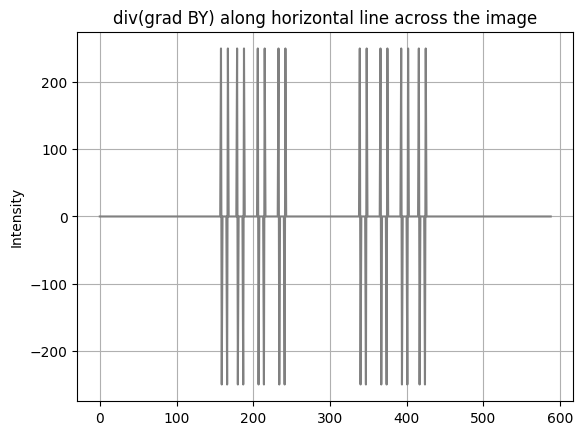

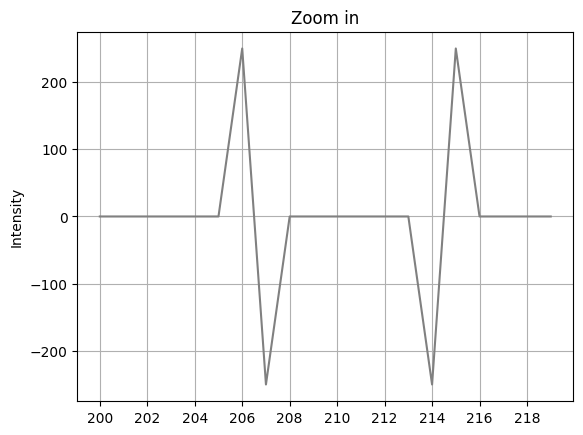

In [ ]:
# Divergence of gradient - BY

Second_Derivative_x_BY = scipy.signal.convolve2d(trig_x_BY, G_odd_x, mode='same')
plt.imshow(Second_Derivative_x_BY, cmap = 'gray')
plt.axis('off')
plt.title('Second_Derivative_x_BY')
plt.show()

Second_Derivative_y_BY = scipy.signal.convolve2d(trig_y_BY, G_odd_y, mode='same')
plt.imshow(Second_Derivative_y_BY, cmap = 'gray')
plt.axis('off')
plt.title('Second_Derivative_y_BY')
plt.show()

Div_of_Trig_BY = Second_Derivative_x_BY + Second_Derivative_y_BY

Div_of_Trig_BY[:, 0] = 0
Div_of_Trig_BY[:, -1] = 0
Div_of_Trig_BY[0, :] = 0
Div_of_Trig_BY[-1, :] = 0

Div_of_Trig_BY[:, 1] = 0
Div_of_Trig_BY[:, -2] = 0
Div_of_Trig_BY[1, :] = 0
Div_of_Trig_BY[-2, :] = 0

div_max = np.max(Div_of_Trig_BY)
div_min = np.min(Div_of_Trig_BY)

height, width = Div_of_Trig_BY.shape

for i in range(height):
  for j in range(width):
    if Div_of_Trig_BY[i, j] > 0:
      Div_of_Trig_BY[i, j] = div_max
    if Div_of_Trig_BY[i, j] < 0:
      Div_of_Trig_BY[i, j] = div_min

plt.imshow(Div_of_Trig_BY, cmap = 'gray')
plt.title('div(grad BY)')
plt.axis('off')
plt.show()

height, width = Div_of_Trig_BY.shape

center_y = height // 2

line_values = Div_of_Trig_BY[center_y, :]
plt.plot(line_values, color='gray')
plt.title('div(grad BY) along horizontal line across the image')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.show()

line_values = Div_of_Trig_BY[center_y, 200:220]
plt.plot(range(200, 220), line_values, color='gray')
plt.title('Zoom in')
plt.xlabel('')
plt.ylabel('Intensity')
plt.xticks(range(200, 220, 2))
plt.grid()
plt.show()

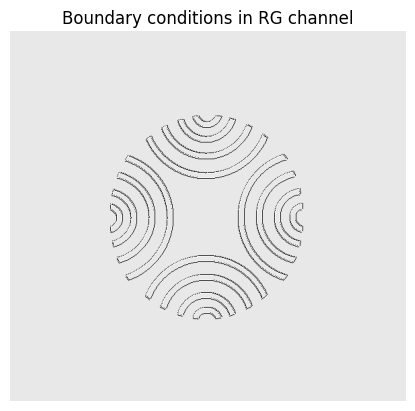

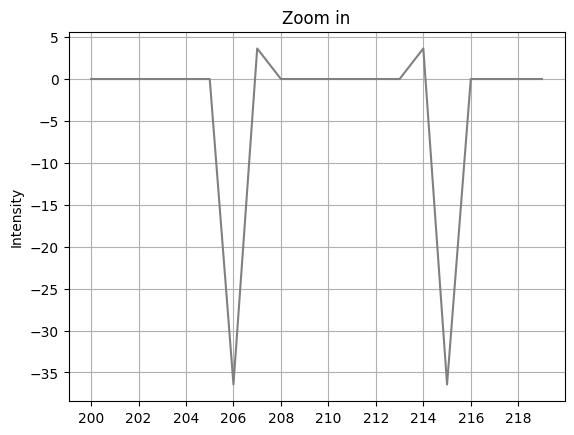

In [ ]:
# Defining the boundary conditions for RG channel

height, width = Div_of_Trig_RG.shape

if RG_chrom >= RG_background:
  D_plus_RG = 1
  D_minus_RG = 0.1
else:
  D_plus_RG = 0.1
  D_minus_RG = 1

for i in range(height):
  for j in range(width):
    if Div_of_Trig_RG[i, j] > 0:
      Div_of_Trig_RG[i, j] = D_plus_RG * Div_of_Trig_RG[i, j]
    if Div_of_Trig_RG[i, j] < 0:
      Div_of_Trig_RG[i, j] = D_minus_RG * Div_of_Trig_RG[i, j]

Boundary_RG = Div_of_Trig_RG

plt.imshow(Boundary_RG, cmap = 'gray')
plt.title('Boundary conditions in RG channel')
plt.axis('off')
plt.show()

height, width = Boundary_RG.shape

center_y = height // 2

line_values = Boundary_RG[center_y, 200:220]
plt.plot(range(200, 220), line_values, color='gray')
plt.title('Zoom in')
plt.xlabel('')
plt.ylabel('Intensity')
plt.xticks(range(200, 220, 2))
plt.grid()
plt.show()

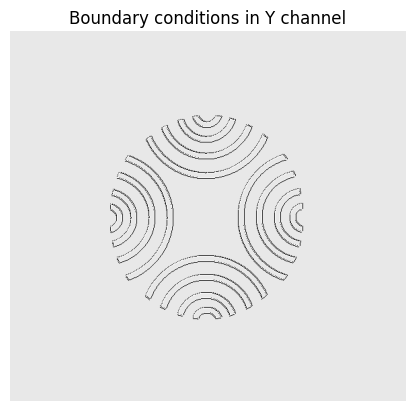

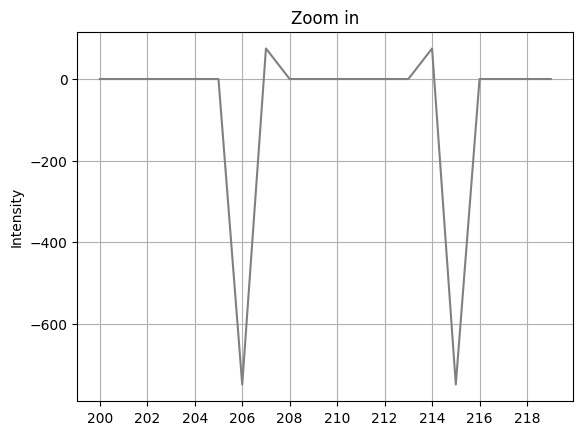

In [ ]:
# Defining the boundary conditions for Y channel

height, width = Div_of_Trig_Y.shape

if Y_chrom >= Y_background:
  D_plus_Y = 1
  D_minus_Y = 0.1
else:
  D_plus_Y = 0.1
  D_minus_Y = 1

for i in range(height):
  for j in range(width):
    if Div_of_Trig_Y[i, j] > 0:
      Div_of_Trig_Y[i, j] = D_plus_Y * Div_of_Trig_Y[i, j]
    if Div_of_Trig_Y[i, j] < 0:
      Div_of_Trig_Y[i, j] = D_minus_Y * Div_of_Trig_Y[i, j]

Boundary_Y = Div_of_Trig_Y

plt.imshow(Boundary_Y, cmap = 'gray')
plt.title('Boundary conditions in Y channel')
plt.axis('off')
plt.show()

height, width = Boundary_Y.shape

center_y = height // 2

line_values = Boundary_Y[center_y, 200:220]
plt.plot(range(200, 220), line_values, color='gray')
plt.title('Zoom in')
plt.xlabel('')
plt.ylabel('Intensity')
plt.xticks(range(200, 220, 2))
plt.grid()
plt.show()

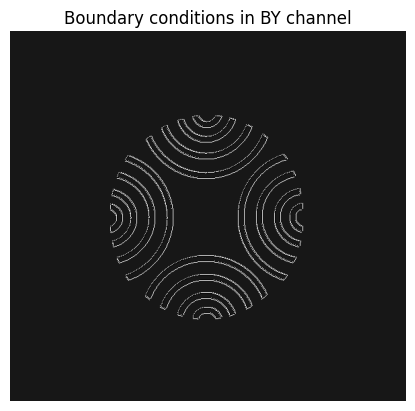

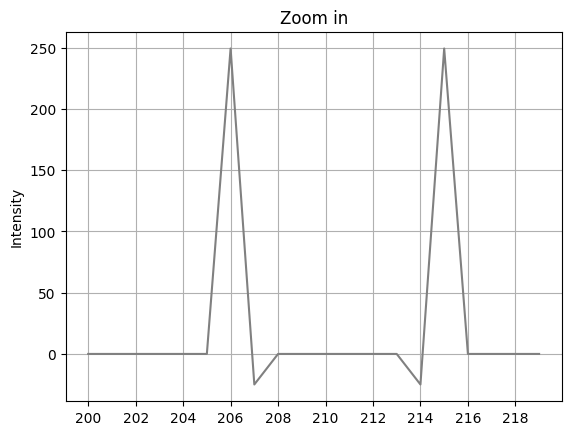

In [ ]:
# Defining the boundary conditions for BY channel

height, width = Div_of_Trig_BY.shape

if BY_chrom >= BY_background:
  D_plus_BY = 1
  D_minus_BY = 0.1
else:
  D_plus_BY = 0.1
  D_minus_BY = 1

for i in range(height):
  for j in range(width):
    if Div_of_Trig_BY[i, j] > 0:
      Div_of_Trig_BY[i, j] = D_plus_BY * Div_of_Trig_BY[i, j]
    if Div_of_Trig_BY[i, j] < 0:
      Div_of_Trig_BY[i, j] = D_minus_BY * Div_of_Trig_BY[i, j]

Boundary_BY = Div_of_Trig_BY

plt.imshow(Boundary_BY, cmap = 'gray')
plt.title('Boundary conditions in BY channel')
plt.axis('off')
plt.show()

height, width = Boundary_BY.shape

center_y = height // 2

line_values = Boundary_BY[center_y, 200:220]
plt.plot(range(200, 220), line_values, color='gray')
plt.title('Zoom in')
plt.xlabel('')
plt.ylabel('Intensity')
plt.xticks(range(200, 220, 2))
plt.grid()
plt.show()

In [ ]:
# Solving Laplace equation in RG channel: Δ(I_diffused_RG) = 0 with boundary conditions

height, width = opponentRG_channel.shape

def solve_Laplace_equation(width, height, iterations=1000, tol=1e-3):

    # Initialize the grid:
    u = np.zeros((height, width))
    u_new = np.zeros((height, width))

    # Perform Jacobi iterations:
    for _ in range(iterations):
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                if Boundary_RG[i, j] == 0:
                    u_new[i, j] = 0.25 * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1])
                else:
                    u_new[i, j] = Boundary_RG[i, j]
                if facilitated_image_blue[i, j] != 0:  # Add additional boundary condition - the diffusion stops on the contour created by orthogoanl completion
                    u_new[i, j] = 0

        # Check for convergence
        if np.max(np.abs(u_new - u)) < tol:
            break

        # Update solution
        u[:] = u_new

    return u

delta_I_RG = solve_Laplace_equation(width, height)

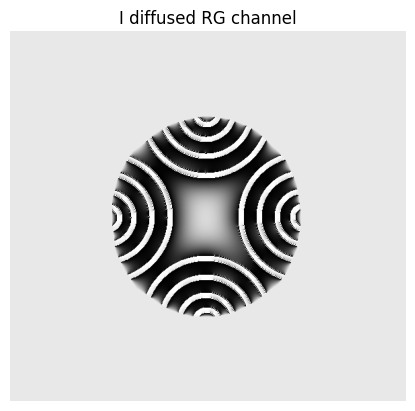

In [ ]:
plt.imshow(delta_I_RG, cmap = 'gray')
plt.title('I diffused RG channel')
plt.axis('off')
plt.show()

In [ ]:
# Solving Laplace equation in Y channel: Δ(I_diffused_Y) = 0 with boundary conditions

height, width = opponentY_channel.shape

def solve_Laplace_equation(width, height, iterations=1000, tol=1e-3):

    # Initialize the grid:
    u = np.zeros((height, width))
    u_new = np.zeros((height, width))

    # Perform Jacobi iterations
    for _ in range(iterations):
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                if Boundary_Y[i, j] == 0:
                    u_new[i, j] = 0.25 * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1])
                else:
                    u_new[i, j] = Boundary_Y[i, j]
                if facilitated_image_blue[i, j] != 0:  # Add additional boundary condition - the diffusion stops on the contour created by orthogoanl completion
                    u_new[i, j] = 0

        # Check for convergence
        if np.max(np.abs(u_new - u)) < tol:
            break

        # Update solution
        u[:] = u_new

    return u

delta_I_Y = solve_Laplace_equation(width, height)

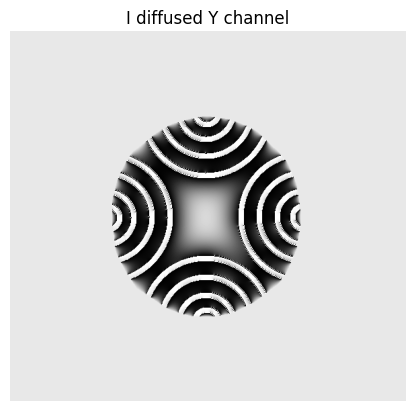

In [ ]:
plt.imshow(delta_I_Y, cmap = 'gray')
plt.title('I diffused Y channel')
plt.axis('off')
plt.show()

In [ ]:
# Solving Laplace equation in BY channel: Δ(I_diffused_BY) = 0 with boundary conditions

height, width = opponentYB_channel.shape

def solve_Laplace_equation(width, height, iterations=1000, tol=1e-3):

    # Initialize the grid:
    u = np.zeros((height, width))
    u_new = np.zeros((height, width))

    # Perform Jacobi iterations
    for _ in range(iterations):
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                if Boundary_BY[i, j] == 0:
                    u_new[i, j] = 0.25 * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1])
                else:
                    u_new[i, j] = Boundary_BY[i, j]
                if facilitated_image_blue[i, j] != 0:  # Add additional boundary condition - the diffusion stops on the contour created by orthogoanl completion
                    u_new[i, j] = 0

        # Check for convergence
        if np.max(np.abs(u_new - u)) < tol:
            break

        # Update solution
        u[:] = u_new

    return u

delta_I_BY = solve_Laplace_equation(width, height)

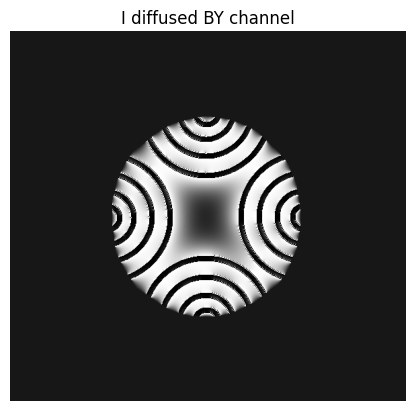

In [ ]:
plt.imshow(delta_I_BY, cmap = 'gray')
plt.title('I diffused BY channel')
plt.axis('off')
plt.show()

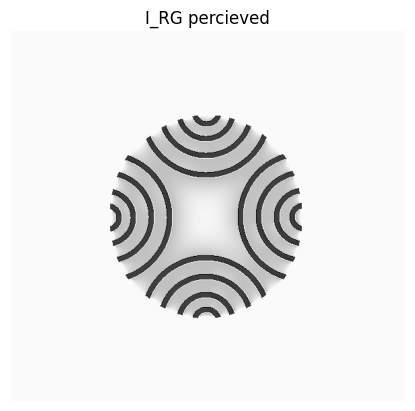

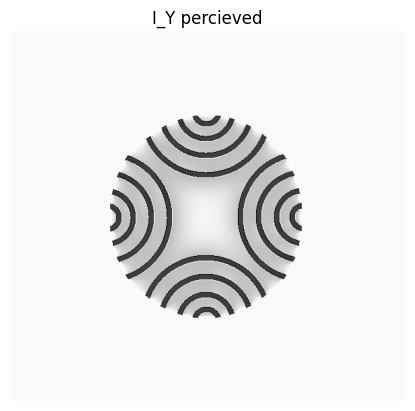

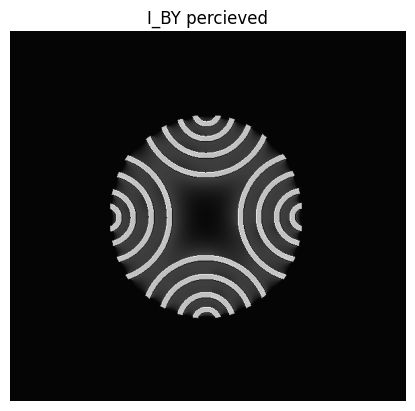

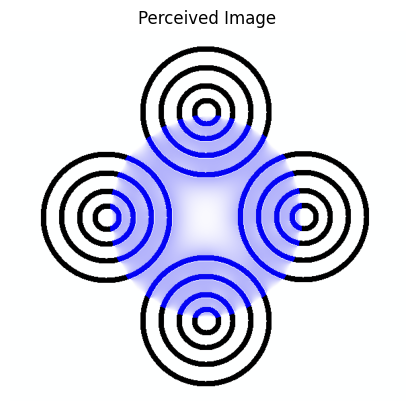

In [ ]:
# For each channel combine the original image and I_diffused

alpha = 0.1  # alpha is the parameter that controls the amount of presence of diffusion in the image in each channel

I_RG = opponentRG_channel + alpha * delta_I_RG
I_Y = opponentY_channel + alpha * delta_I_Y
I_BY = opponentYB_channel + alpha * delta_I_BY

plt.imshow(I_RG , cmap = 'gray')
plt.title('I_RG percieved')
plt.axis('off')
plt.show()
plt.imshow(I_Y , cmap = 'gray')
plt.title('I_Y percieved')
plt.axis('off')
plt.show()
plt.imshow(I_BY , cmap = 'gray')
plt.title('I_BY percieved')
plt.axis('off')
plt.show()

# Perform inverse transformation to return back to the RGB color space:
R_channel = (-6.4315076506366820439)*I_RG + 1.1677127390847542369*I_Y - 0.50436819725514334708*I_BY
G_channel = 2.5970087130385898641*I_RG + 0.90137958831127302493*I_Y + 0.015899678653173692632*I_BY
B_channel = 0.12573052951392914592*I_RG + 0.72144948042615882536*I_Y + 2.0516930040442857355*I_BY

Percieved_Image = (cv2.merge([R_channel, G_channel, B_channel]))/255
Percieved_Image = np.clip(Percieved_Image, 0, 1)

height, width = opponentYB_channel.shape
for i in range(height):
  for j in range(width):
    if not_chromatic_only[i, j][0] == 0 and not_chromatic_only[i, j][1] == 0 and not_chromatic_only[i, j][2] == 0:
      Percieved_Image[i, j] = not_chromatic_only[i, j]

plt.imshow(Percieved_Image , cmap = 'gray')
plt.title('Perceived Image')
plt.axis('off')
plt.show()

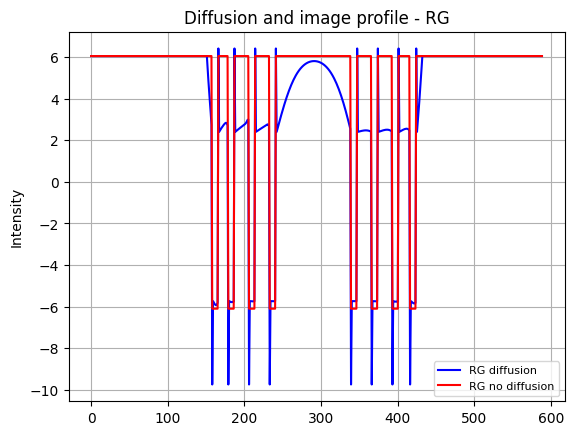

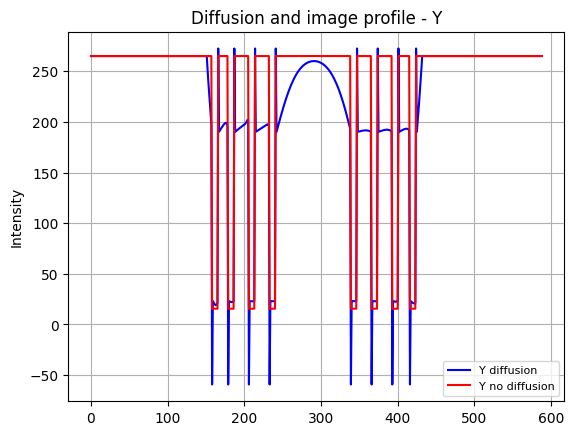

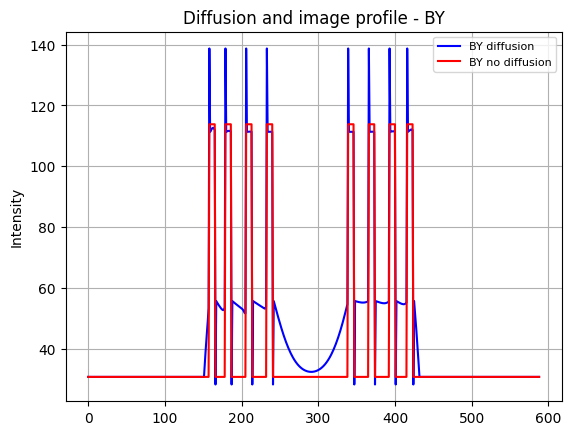

In [ ]:
# Side profile of RG diffusion

height, width = I_RG.shape

center_y = height // 2
center_x = width // 2

line_values_diff = I_RG[center_y, :]
line_values_RG = opponentRG_channel[center_y, :]

plt.plot(line_values_diff, label='RG diffusion', color='blue')
plt.plot(line_values_RG, label='RG no diffusion', color='red')
plt.title('Diffusion and image profile - RG')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.legend(loc='lower right', prop={'size': 8})
plt.show()

# Side profile of Y diffusion

line_values_diff = I_Y[center_y, :]
line_values_Y = opponentY_channel[center_y, :]

plt.plot(line_values_diff, label='Y diffusion', color='blue')
plt.plot(line_values_Y, label='Y no diffusion', color='red')
plt.title('Diffusion and image profile - Y')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.legend(loc='lower right', prop={'size': 8})
plt.show()

# Side profile of BY diffusion

line_values_diff = I_BY[center_y, :]
line_values_BY = opponentYB_channel[center_y, :]

plt.plot(line_values_diff, label='BY diffusion', color='blue')
plt.plot(line_values_BY, label='BY no diffusion', color='red')
plt.title('Diffusion and image profile - BY')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.legend(loc='upper right', prop={'size': 8})
plt.show()

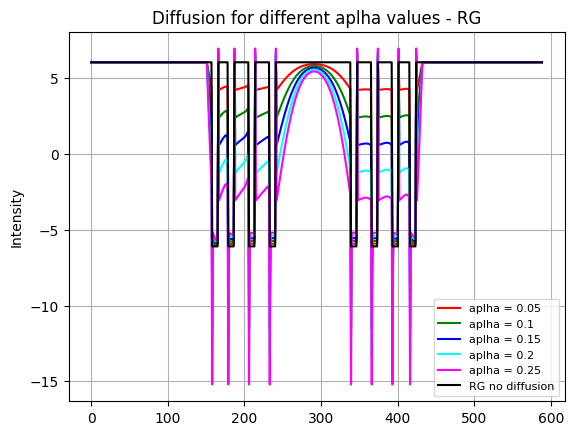

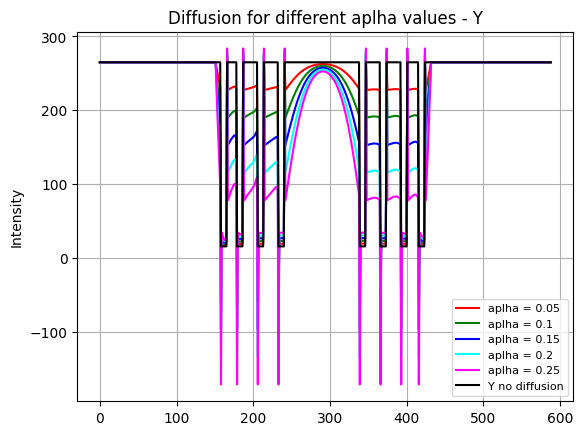

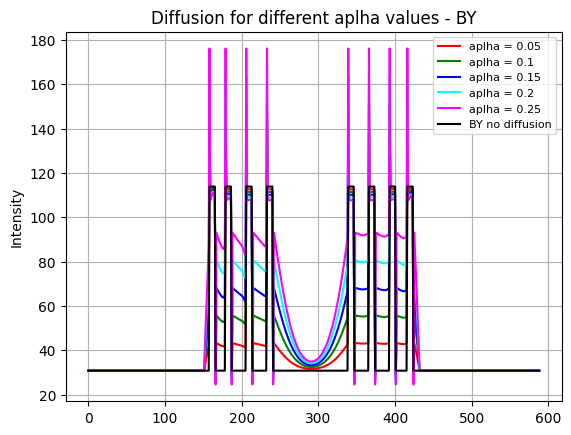

In [ ]:
# Changing value of alpha - RG diffusion profile

for alpha in [0.05, 0.1, 0.15, 0.2, 0.25]:
  I_RG = opponentRG_channel + alpha * delta_I_RG
  line_values_diff = I_RG[center_y, :]
  if alpha == 0.05:
    plt.plot(line_values_diff, label='aplha = 0.05', color='red')
  if alpha == 0.1:
    plt.plot(line_values_diff, label='aplha = 0.1', color='green')
  if alpha == 0.15:
    plt.plot(line_values_diff, label='aplha = 0.15', color='blue')
  if alpha == 0.2:
    plt.plot(line_values_diff, label='aplha = 0.2', color='cyan')
  if alpha == 0.25:
    plt.plot(line_values_diff, label='aplha = 0.25', color='magenta')

line_values_RG = opponentRG_channel[center_y, :]
plt.plot(line_values_RG, label='RG no diffusion', color='black')
plt.title('Diffusion for different aplha values - RG')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.legend(loc='lower right', prop={'size': 8})
plt.show()

# Changing value of alpha - Y diffusion profile

for alpha in [0.05, 0.1, 0.15, 0.2, 0.25]:
  I_Y = opponentY_channel + alpha * delta_I_Y
  line_values_diff = I_Y[center_y, :]
  if alpha == 0.05:
    plt.plot(line_values_diff, label='aplha = 0.05', color='red')
  if alpha == 0.1:
    plt.plot(line_values_diff, label='aplha = 0.1', color='green')
  if alpha == 0.15:
    plt.plot(line_values_diff, label='aplha = 0.15', color='blue')
  if alpha == 0.2:
    plt.plot(line_values_diff, label='aplha = 0.2', color='cyan')
  if alpha == 0.25:
    plt.plot(line_values_diff, label='aplha = 0.25', color='magenta')

line_values_Y = opponentY_channel[center_y, :]
plt.plot(line_values_Y, label='Y no diffusion', color='black')
plt.title('Diffusion for different aplha values - Y')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.legend(loc='lower right', prop={'size': 8})
plt.show()

# Changing value of alpha - BY diffusion profile

for alpha in [0.05, 0.1, 0.15, 0.2, 0.25]:
  I_BY = opponentYB_channel + alpha * delta_I_BY
  line_values_diff = I_BY[center_y, :]
  if alpha == 0.05:
    plt.plot(line_values_diff, label='aplha = 0.05', color='red')
  if alpha == 0.1:
    plt.plot(line_values_diff, label='aplha = 0.1', color='green')
  if alpha == 0.15:
    plt.plot(line_values_diff, label='aplha = 0.15', color='blue')
  if alpha == 0.2:
    plt.plot(line_values_diff, label='aplha = 0.2', color='cyan')
  if alpha == 0.25:
    plt.plot(line_values_diff, label='aplha = 0.25', color='magenta')

line_values_BY = opponentYB_channel[center_y, :]
plt.plot(line_values_BY, label='BY no diffusion', color='black')
plt.title('Diffusion for different aplha values - BY')
plt.xlabel('')
plt.ylabel('Intensity')
plt.grid()
plt.legend(loc='upper right', prop={'size': 8})
plt.show()

The following part is combining the orthogonal completion perceived image and the diffusion perceived image

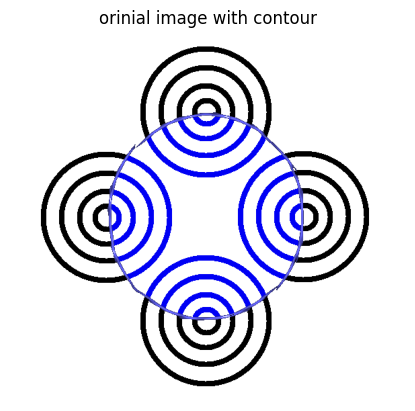

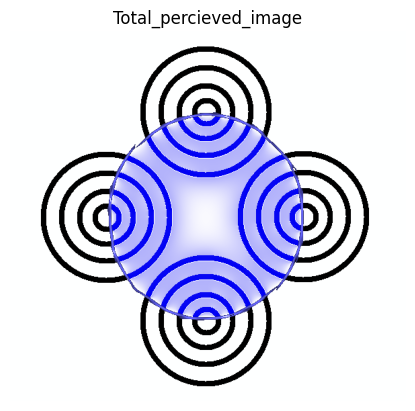

In [ ]:
# Combine the orthogonal completion image (contour image) with the original image and with diffusion image

height, width = facilitated_image_blue.shape

Percieved_Image = (Percieved_Image * 255).astype(np.uint8)

for i in range(height):
  for j in range(width):
    if color_contour[i, j][dominant_channel] > 60:
      if Saturated_contour[i, j][0] != 0 or Saturated_contour[i, j][1] != 0 or Saturated_contour[i,j][2] != 0:
        rgb_image[i, j][0] = Saturated_contour[i, j][0]
        rgb_image[i, j][1] = Saturated_contour[i, j][1]
        rgb_image[i, j][2] = Saturated_contour[i, j][2]
        Percieved_Image[i, j][0] = Saturated_contour[i, j][0]
        Percieved_Image[i, j][1] = Saturated_contour[i, j][1]
        Percieved_Image[i, j][2] = Saturated_contour[i, j][2]

plt.imshow(rgb_image)
plt.title('orinial image with contour')
plt.axis('off')
plt.show()

Total_percieved_image = Percieved_Image
plt.imshow(Total_percieved_image)
plt.title('Total_percieved_image')
plt.axis('off')
plt.show()

The following part is optional and a sort of test we applied to check our results. It does not necessarily valuable, but we left it here for a possible use in the future.

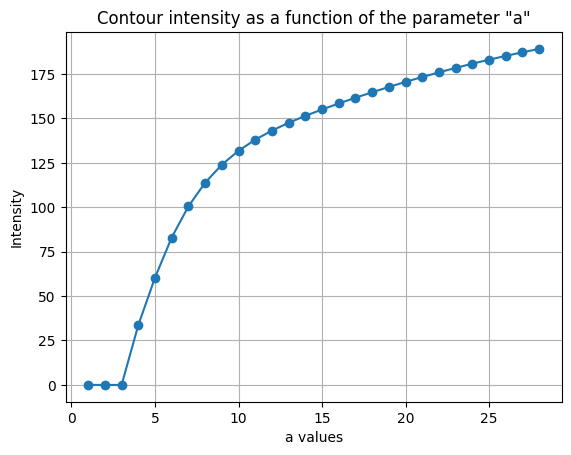

In [ ]:
# Graph of a values vs contour intensity along diagonal line on the image

I_Gabor_x, I_Gabor_y = ConvolutionWithGabor(blue_enhanced)
I_Gabor_Th_x, I_Gabor_Th_y, max_val_y = ApplyThreshold(I_Gabor_x, I_Gabor_y, 0.8)
I_Edges = CombineThresholdEdges(I_Gabor_Th_x, I_Gabor_Th_y)
I_Edges = ApplyAdditionalThreshold(I_Edges, max_val_y)
result = FindOrientations(I_Edges)

height, width = facilitated_image_blue.shape

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
max_contour_val = np.zeros(28)
for i in range(0, 28):
  b = 1.2
  facilitated_image_blue = AdditiveSignal(I_Edges, result, a[i], b)
  diagonal_values = [facilitated_image_blue[height - 1 - i, i] for i in range(min(height, width))]
  max_contour_val[i] = np.max(diagonal_values)

plt.plot(a, max_contour_val, marker = 'o')
plt.title('Contour intensity as a function of the parameter "a"')
plt.xlabel('a values')
plt.ylabel('Intensity')
plt.grid()
plt.show()